這個 colab 示範 OpenAI Agents SDK

* https://openai.github.io/openai-agents-python/
* https://github.com/openai/openai-agents-python/tree/main/examples
* https://github.com/openai/openai-agents-python/tree/main/examples/agent_patterns

In [1]:
from google.colab import userdata
openai_api_key = userdata.get('openai_api_key')

In [2]:
!pip install openai-agents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.6 MB/s eta 0:00:00


In [3]:
from agents import Agent, Runner, set_default_openai_key, function_tool, trace, ItemHelpers

set_default_openai_key(openai_api_key)

## 1. Handoffs: 雙層客服示範

https://openai.github.io/openai-agents-python/handoffs/

* 當發生交接時，就好像新的代理人接管了對話，預設情況會看到整個先前的對話歷史
* WARNING: agent name 不能打中文，因為 code 內部把 agent name 當作 handoff 的 function name 然後中文被濾掉了
* 有功能可以在交接時，過濾掉一些 messages

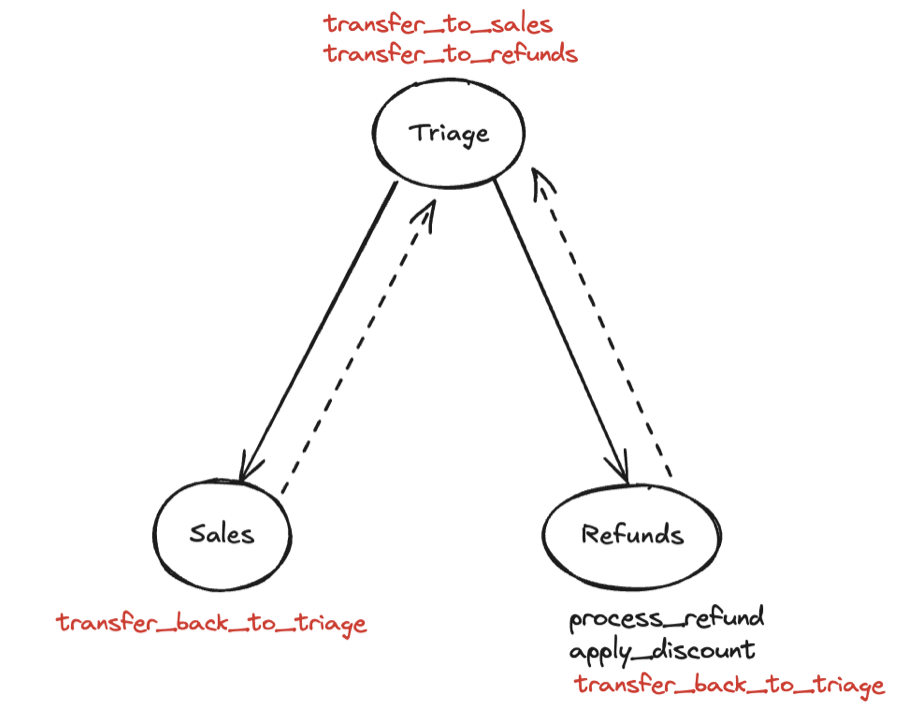

In [4]:
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX

@function_tool
def process_refund(item_name: str):
    """執行商品退款"""
    print(f"  ⚙️ 呼叫函式 process_refund: {item_name}")

    # TODO: 將資料寫入資料庫
    return "success"

@function_tool
def process_order(item_name: str):
    """執行購買下單"""
    print(f"  ⚙️ 呼叫函式 process_order: {item_name}")

    # TODO: 將資料寫入資料庫
    return "success"

sales_agent = Agent(
    name="Sales Agent", # 不要打中文，因為這名子拿來定義 function name，中文會被濾掉
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
您是專業的銷售代理，負責協助客戶購買商品。一律用台灣繁體中文進行回覆。
當客戶開始詢問與產品購買無關的話題時，將對話轉接給 TriageAgent""",
    tools=[process_order],
    model="gpt-4.1",
)

refunds_agent = Agent(
    name="Refund Agent",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
您是專業的退款處理專員，負責高效處理退款請求。一律用台灣繁體中文進行回覆。
當客戶開始詢問與退款無關的話題時，將對話轉接給 TriageAgent""",
    tools=[process_refund],
    model="gpt-4.1"
)

triage_agent = Agent(
    name="Triage Agent",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
您是客服團隊的首席分流專員，負責高效判斷並分配客戶請求。

1. 迅速分析客戶請求的主要意圖和需求類型
2. 根據以下標準分流請求:
    - 產品購買、價格諮詢、產品功能 → 轉接 SalesAgent
    - 退款請求、價格投訴、產品不滿意 → 轉接 RefundAgent
3. 保持對話連貫性，無痕轉接

一律用台灣繁體中文進行回覆。
""",
    handoffs = [sales_agent, refunds_agent],
    model="gpt-4.1"
)

# Pro Tip: 因為定義的順序，這裡補上 triage_agent
sales_agent.handoffs.append(triage_agent)
refunds_agent.handoffs.append(triage_agent)

# ----


messages = []
current_agent = triage_agent

with trace("handoff-demo"):
  while True:
      user_input = input("User: ")

      if user_input == 'q':
        break

      messages.append({"role": "user", "content": user_input})

      result = await Runner.run(current_agent, input=messages)

      print("-----")
      print(f"{result.last_agent.name}: {result.final_output}")

      messages = result.to_input_list()

      current_agent = result.last_agent

User: hi
-----
Triage Agent: 您好，請問有什麼可以協助您的地方嗎？
User: 我要退款
-----
Refund Agent: 請問您要退款的商品名稱是什麼呢？請提供相關資訊，好讓我協助您處理退款。
User: 退 XYZ
  ⚙️ 呼叫函式 process_refund: XYZ
-----
Refund Agent: 您的「XYZ」商品退款申請已經成功受理。我們會盡快處理，相關款項將於作業完成後退還至您的原付款方式。如有其他問題歡迎再與我們聯繫！
User: 我要買東西
-----
Sales Agent: 請問您想購買什麼商品呢？請提供商品名稱或其他相關資訊，我會協助您下單！
User: q


### 小改進: 呼叫工具時，需要人類確認 Confirmation

Pro tip: tool 的回傳值，是要給 AI 看的: 執行成功 or 失敗原因，需要回覆給 AI，讓 AI 判斷接下來如何處理和回覆用戶

In [5]:
@function_tool
def process_refund_v2(item_name: str):
    """執行商品退款"""

    user_input = input(" ⚠️ 請確認是否執行 process_refund? 請輸入 'y' 確定，或輸入取消原因.")

    if user_input.strip() == "y":
      # TODO: 將資料寫入資料庫
      return "Refund has been processed successfully."
    else:
      return f"Refund was cancelled by the user: {user_input}"


@function_tool
def process_order_v2(item_name: str):
    """執行購買下單"""

    user_input = input(" ⚠️ 請確認是否執行 process_order ? 請輸入 'y' 確定，或輸入取消原因.")

    if user_input.strip() == "y":
      # TODO: 將資料寫入資料庫
      return "Order has been processed successfully."
    else:
      return f"Order was cancelled by the user: {user_input}"

In [6]:
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX

sales_agent = Agent(
    name="Sales Agent", # 不要打中文，因為這名子拿來定義 function name，中文會被濾掉
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
您是專業的銷售代理，負責協助客戶購買商品。一律用台灣繁體中文進行回覆。
當客戶開始詢問與產品購買無關的話題時，將對話轉接給 TriageAgent""",
    tools=[process_order_v2],
    model="gpt-4.1"
)

refunds_agent = Agent(
    name="Refund Agent",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
您是專業的退款處理專員，負責高效處理退款請求。一律用台灣繁體中文進行回覆。
當客戶開始詢問與退款無關的話題時，將對話轉接給 TriageAgent""",
    tools=[process_refund_v2],
    model="gpt-4.1"
)

triage_agent = Agent(
    name="Triage Agent",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
您是客服團隊的首席分流專員，負責高效判斷並分配客戶請求。

1. 迅速分析客戶請求的主要意圖和需求類型
2. 根據以下標準分流請求:
    - 產品購買、價格諮詢、產品功能 → 轉接 SalesAgent
    - 退款請求、價格投訴、產品不滿意 → 轉接 RefundAgent
3. 保持對話連貫性，無痕轉接

一律用台灣繁體中文進行回覆。
""",
    handoffs = [sales_agent, refunds_agent],
    model="gpt-4.1"
)

# 因為定義的順序，這裡補上 triage_agent
sales_agent.handoffs.append(triage_agent)
refunds_agent.handoffs.append(triage_agent)

# ----


messages = []
current_agent = triage_agent

with trace("handoff-demo"):
  while True:
      user_input = input("User: ")

      if user_input == 'q':
        break

      messages.append({"role": "user", "content": user_input})

      result = await Runner.run(current_agent, input=messages)

      print("-----")
      print(f"{result.last_agent.name}: {result.final_output}")

      messages = result.to_input_list()

      current_agent = result.last_agent

User: 我要退款
-----
Refund Agent: 請問您要申請哪一項商品或服務的退款？請提供商品名稱或訂單相關資訊，好讓我協助您處理退款申請。
User: 退 XYZ
 ⚠️ 請確認是否執行 process_refund? 請輸入 'y' 確定，或輸入取消原因.y
-----
Refund Agent: 您的「XYZ」商品退款申請已成功完成。  
款項會依原付款方式退還，請留意您的帳戶。若有其他問題，歡迎隨時聯絡我們。
User: 我要買 ABC
-----
Triage Agent: 您想購買「ABC」這項商品，請稍等，將由專人協助您進行購買流程或提供相關資訊。
User: 購買 ABC
-----
Sales Agent: 您想購買「ABC」這項商品，請稍候，將由專人協助您完成購買流程。
User: 購買 ABC
 ⚠️ 請確認是否執行 process_order ? 請輸入 'y' 確定，或輸入取消原因.不要，後悔了
-----
Sales Agent: 您剛剛已取消購買「ABC」，如有需要再購買或其他協助，請隨時告訴我！
User: q


## 2. Agents as Tools 示範

https://openai.github.io/openai-agents-python/tools/#agents-as-tools

不像 handoffs，Agents 們會看到整個對話串。在 Agents as Tools 中，子 agent 是各自獨立的

In [8]:
spanish_agent = Agent(
    name="spanish_agent",
    instructions="你將用戶的訊息翻譯成西班牙語",
)

french_agent = Agent(
    name="french_agent",
    instructions="你將用戶的訊息翻譯成法語",
)

italian_agent = Agent(
    name="italian_agent",
    instructions="你將用戶的訊息翻譯成義大利語",
)

orchestrator_agent = Agent(
    model="gpt-4.1-mini",
    name="orchestrator_agent",
    instructions=("""你是一個專門負責「翻譯」的代理。你不直接進行翻譯，而是透過提供給你的工具來完成翻譯任務。
你的指示如下：

1. 所有翻譯工作都必須使用指定工具執行，你絕不自行翻譯任何文字。
2. 與使用者互動時，一律使用台灣繁體中文。
3. 無論使用者說什麼，你都應使用工具來進行翻譯。
4. 如果使用者沒有指定要翻譯成哪一種語言，請依序呼叫下列工具：spanish_agent, french_agent, italian_agent"""
    ),
    tools=[
        spanish_agent.as_tool(
            tool_name="translate_to_spanish",
            tool_description="將用戶的訊息翻譯成西班牙語",
        ),
        french_agent.as_tool(
            tool_name="translate_to_french",
            tool_description="將用戶的訊息翻譯成法語",
        ),
        italian_agent.as_tool(
            tool_name="translate_to_italian",
            tool_description="將用戶的訊息翻譯成義大利語",
        ),
    ],
)

In [9]:
with trace("agents-as-tools-demo"):
  while True:
      user_input = input("User: ")

      if user_input == 'q':
        break

      messages.append({"role": "user", "content": user_input})

      result = await Runner.run(orchestrator_agent, input=messages)

      print("-----")
      print(f"{result.last_agent.name}: {result.final_output}")

      messages = result.to_input_list()

      current_agent = result.last_agent

User: 測試
-----
orchestrator_agent: 「測試」翻譯結果如下：
- 西班牙語：Prueba
- 法語：Tester
- 義大利語：Test

請問還需要翻譯成其他語言嗎？
User: q


> 案例: Google A2A 的實作，也是用 Agents as Tool 達成: https://www.facebook.com/ihower/posts/10162264917918971

## 3. Deterministic flows 範例

* 我們也可以用 agents 來做 workflow 流程，而且 Agent 也是支援 Structured Output 的，方便串接
* 其實 一個沒有工具的 agent，等同於一個 prompt completion 呼叫

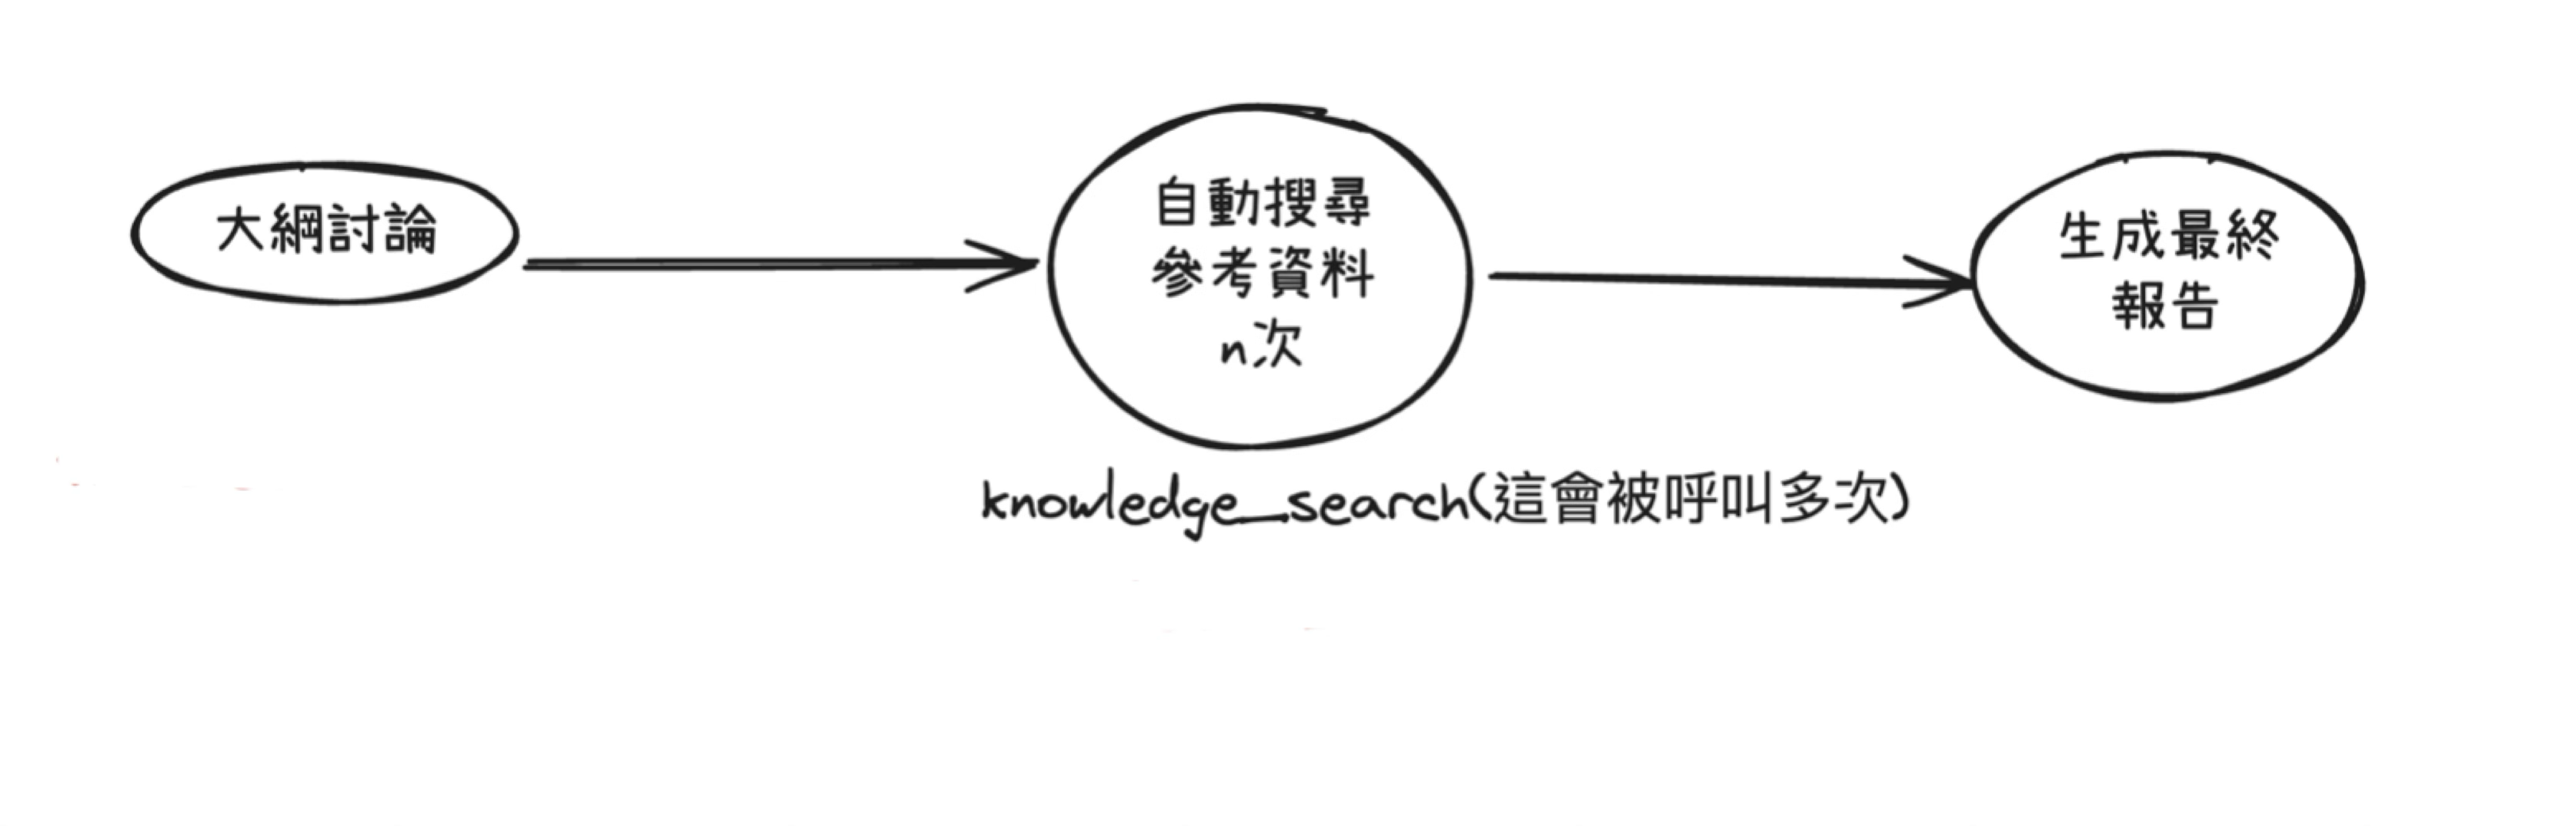

In [10]:
!pip install tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s eta 0:00:00


In [11]:
tavily_api_key = userdata.get('tavily_api_key')

In [12]:
from tavily import AsyncTavilyClient
tavily_client = AsyncTavilyClient(api_key=tavily_api_key)

@function_tool
async def perform_web_search(query: str):
    """Perform web search"""
    print(f"  🔍 進行 web search: {query}")

    search_response = await tavily_client.search(query, max_results=6)
    contexts = search_response["results"]
    # print(f"    Tavily search results: {contexts}")
    return str(contexts)

In [13]:
from pydantic import BaseModel, Field

# Agent 1
class OutlineResult(BaseModel):
    subjects: list[str] = Field(description="列出研究報告的主要章節標題，每個標題應簡潔明確地描述該章節將涵蓋的內容。")

outline_agent = Agent(
    name="outline_agent",
    instructions="""你是一位專業研究報告規劃專家。你的任務是根據用戶提供的主題，設計一份結構清晰的研究報告大綱。

請遵循以下準則：
1. 分析主題的核心要素，確定最重要的2-3個面向
2. 為每個面向創建一個明確、具體的標題
3. 標題應具邏輯順序，從基礎概念到進階分析
4. 使用簡潔有力的標題文字，避免過於冗長或模糊的表述

請輸出不超過三點的大綱標題。所有回答必須使用繁體中文。""",

    output_type=OutlineResult,
    model="gpt-4.1-mini"
)


# Agent 2
class SearchResult(BaseModel):
    references: list[str] = Field(description="從網頁搜尋結果中直接擷取與研究主題相關的原始段落，保持原文不變。請確保只擷取最相關且有用的內容片段，不要修改或重新詮釋原文。")

search_agent = Agent(
    name="search_agent",
    instructions="""你是一位精準的研究資料蒐集專家。你的任務是針對給定的研究主題搜集最相關且可靠的參考資料。

請遵循以下工作流程：
1. 每個主題使用 perform_web_search 工具進行有針對性的搜索
3. 評估搜索結果的相關性、可靠性和時效性
4. 從搜索結果中提取與主題直接相關的重要資訊
5. 組織參考資料，確保每個子問題都有充分且多元的支持資料

每個子問題最多擷取三份高質量參考資料，避免重複或冗餘資訊。""",
    output_type=SearchResult,
    tools=[perform_web_search],
    model="gpt-4.1-mini"
)

# Agent 3
report_agent = Agent(
    name="report_agent",
    instructions="""你是一位專業研究報告撰寫專家。你的任務是根據提供的大綱和參考資料，撰寫一份全面、深入且結構清晰的研究報告。

請遵循以下撰寫原則：
1. 嚴格按照大綱結構組織內容，確保邏輯連貫
2. 充分利用所有提供的參考資料，準確引用並整合資訊
3. 使用客觀、專業且精準的語言表達
4. 平衡地呈現不同觀點，避免偏見
5. 在每個章節結尾提供簡潔的小結
6. 適當添加圖表或列表以增強內容清晰度（如適用）
7. 提供具體的結論和建議（如適用）

報告格式應包含：
- 簡短摘要（100-150字）
- 按大綱組織的主體內容
- 結論與建議

所有內容必須使用繁體中文撰寫，確保用詞準確且符合台灣用語習慣。""",
    model="gpt-4.1"
)

In [14]:
async def research_e2e(query):
  with trace("Research Agents"):
    # Agent 1
    print("🔄 Agent 1 處理...")
    result1 = await Runner.run(outline_agent, input=query)
    subjcets = str(result1.final_output.subjects)

    # Agent 2
    print("🔄 Agent 2 處理...")
    result2 = await Runner.run(search_agent, input=subjcets)
    references = str(result2.final_output.references)

    # Agent 3
    print("🔄 Agent 3 處理...")
    report_input = f"""
這是報告大綱: <subjects>{subjcets}</subjects>
這是參考資料: <reference>{references}</reference>
  """

    result3 = await Runner.run(report_agent, input=report_input)

    return result3.final_output

In [15]:
report = await research_e2e("新台幣升值會造成什麼影響")

print(report)

🔄 Agent 1 處理...
🔄 Agent 2 處理...
  🔍 進行 web search: 新台幣升值的經濟基礎與原因分析
  🔍 進行 web search: 新台幣升值對出口及產業結構的影響
  🔍 進行 web search: 新台幣升值對消費者與國內金融市場的影響
🔄 Agent 3 處理...
---
## 摘要

近年來新台幣顯著升值，對台灣經濟產生多方面影響。本文依據公開資料及權威來源，深入探討新台幣升值的經濟基礎與推動原因，解析其對台灣出口及產業結構的連鎖效應，進而評估對國內消費者與金融市場的具體影響。本文以數據及現象佐證，客觀展現不同觀點，提供台灣應對新台幣升值挑戰的具體策略建議。

---

## 一、新台幣升值的經濟基礎與原因分析

### 1.1 全球貨幣寬鬆與資金流動

2020年以來，全球迎來寬鬆貨幣政策，主要經濟體為應對疫情，大量釋放資金至市場，影響全球資產價格與資金流向。根據[資料1](https://vocus.cc/article/68185fb6fd89780001c7ef6c)及[資料5](https://www.thenewslens.com/article/252519)，資金熱潮促使亞洲新興市場貨幣升值，新台幣受益於資金湧入，成為強勢表現貨幣之一。

| 主要因素                | 說明                                                |
|------------------------|-----------------------------------------------------|
| 全球資金充裕            | 美國、日本、歐洲等央行量化寬鬆，推動熱錢流入         |
| 台灣本地經濟穩健        | 出口實績亮眼，貿易順差增加，吸引外資                |
| 外資回流                | 國際資本尋求優質市場，台股成長吸引投資者            |

### 1.2 台灣經濟表現與出口力道

台灣疫情控制有效，電子零組件、半導體等產業旺盛[資料1]。2020下半年出口連續創新高，外銷訂單增長明顯。經濟成長強勁，有效推動新台幣需求。

### 1.3 央行政策與市場預期


## 改進: 把 Agent 2 改成 Parallelization 加速 (這整個就變成 Orchestrator-workers 了)

<img src="https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F8985fc683fae4780fb34eab1365ab78c7e51bc8e-2401x1000.png&w=3840&q=75">

In [16]:
import asyncio
async def research_parallel_e2e(query):
  with trace("Research Agents"):
    # Agent 1
    print("🔄 Agent 1 處理...")
    result1 = await Runner.run(outline_agent, input=query)
    subjects = result1.final_output.subjects

    # Agent 2
    print("🔄 Agent 2 處理...")

    # 平行執行多個搜尋代理
    search_tasks = []
    for subject in subjects:
        search_tasks.append(Runner.run(search_agent, input=subject))

    # 等待所有搜尋任務完成
    search_results = await asyncio.gather(*search_tasks)

    # 收集所有 Agent 2 的結果
    all_references = []
    for result in search_results:
        all_references.append(str(result.final_output.references))

    references = str(all_references)

    # Agent 3
    print("🔄 Agent 3 處理...")
    report_input = f"""
這是報告大綱: <subjects>{subjects}</subjects>
這是參考資料: <reference>{references}</reference>
  """

    result3 = await Runner.run(report_agent, input=report_input)

    return result3.final_output

In [17]:
report = await research_parallel_e2e("新台幣升值會造成什麼影響")

print(report)

🔄 Agent 1 處理...
🔄 Agent 2 處理...
  🔍 進行 web search: 新台幣升值 基本概念 與 成因
  🔍 進行 web search: 新台幣升值 對國內經濟與產業的影響
  🔍 進行 web search: 新台幣升值 進出口貿易 影響
🔄 Agent 3 處理...


CancelledError: 

### 改進: Agent 1 加入 human-in-the-loop 進行討論

Agent 1 的作用就是用戶討論進行 "收集參數"

In [18]:
class QueryResult(BaseModel):
    # 我們用這個 Field 來判斷在 用戶對話 loop 中，何時要結束聊天，進到下一關
    is_final_answer: bool = Field(
        description="Indicates whether the user has confirmed the final outline. True means the user has confirmed and ready to proceed to the next stage; False means still in discussion."
    )
    conversation_text: str = Field(
        description="The conversational text with the user for guidance, questions, or responses. This field should ONLY contain dialogue and NEVER include any outline content."
    )
    outline_content: str = Field(
        description="The actual outline content for the research report. This is where ALL outline content must be placed. Keep this field empty if the user hasn't provided a clear topic yet."
    )

# Agent 1 改成 Human-in-the-loop
draft_agent = Agent(
    name="draft_agent",
    instructions="""You are a professional research report planning consultant. Your tasks are:

1. Guide users to provide a clear research report topic
2. Based on the topic provided, help draft a concise research report outline (maximum three main points)
3. Interact with users to discuss, receive feedback, and adjust the outline content
4. Set is_final_answer to True when the user clearly expresses satisfaction or confirms the outline

IMPORTANT FIELD USAGE RULES:
- conversation_text: ONLY for dialogue content. NEVER include any outline in this field.
- outline_content: ALL outline content must be placed ONLY in this field, not mixed into the conversation field.

Workflow:
- During initial interaction, kindly ask the user about their desired research report topic
- After obtaining the topic, provide an initial outline in the outline_content field, and use conversation_text to ask for user feedback
- Continue to optimize the outline in outline_content based on user feedback until the user confirms satisfaction
- After confirmation, inform the user that you will transfer to the search specialist for the next step of data collection

Notes:
- ALWAYS respond in Traditional Chinese (Taiwan variant)
- The outline should be concise and clear, with a maximum of three main points
- Keep outline_content empty if the user has not provided a topic
- Strictly separate conversation content and outline content into their respective fields
- Outline content should ONLY appear in the outline_content field, and should NEVER appear partially or completely in the conversation_text field

Remember: Your output must be in Traditional Chinese (Taiwan variant), but you must follow these English instructions precisely regarding field usage.
""",
    output_type=QueryResult,
    model="gpt-4.1"
)


把 agent1 跟用戶對話的部分，包成一個 talk_to_draft_agent function

In [19]:
async def talk_to_draft_agent():
  messages = []

  while True:
      user_input = input("User: ")

      messages.append({"role": "user", "content": user_input})

      result = await Runner.run(draft_agent, input=messages)

      print(f"🤖 AI: {result.final_output.conversation_text}")

      if result.final_output.outline_content:
        print("-------")
        print(f"  📝 目前草稿大綱: {result.final_output.outline_content}")
        print("-------")

      if result.final_output.is_final_answer:
        outline_content = result.final_output.outline_content
        print(f"  📝 最後大綱: {result.final_output.outline_content}")

        return outline_content

      messages = result.to_input_list()

這是主流程

In [20]:
async def research_e2e_with_human():
  with trace("Research Agents + Human"):
    # Agent 1
    print("🔄 Agent 1 處理...")
    subjcets = await talk_to_draft_agent()

    # Agent 2
    print("🔄 Agent 2 處理...")
    result2 = await Runner.run(search_agent, input=subjcets)
    references = str(result2.final_output.references)

    # Agent 3
    print("🔄 Agent 3 處理...")
    report_input = f"""
這是報告大綱: <subjects>{subjcets}</subjects>
這是參考資料: <reference>{references}</reference>
  """

    result3 = await Runner.run(report_agent, input=report_input)

    return result3.final_output

In [21]:
report = await research_e2e_with_human()

🔄 Agent 1 處理...
User: 我想研究台積電
🤖 AI: 很高興您選擇研究台積電！請問您對台積電有沒有特定的研究角度或主題，例如產業競爭力、創新技術、永續發展或財務表現等？如果沒有特定方向，我可以先提出一個基本的研究大綱，供您參考和調整。請您告訴我您的想法！
User: 研究 AI 相關
🤖 AI: 了解，您想聚焦於台積電與 AI 相關的主題。以下是根據此方向擬定的初步大綱，請您確認是否符合您的需求，或需要進一步調整內容或重點。歡迎任何建議！
-------
  📝 目前草稿大綱: 1. 台積電在 AI 晶片製造的技術與市場地位
2. 台積電與全球 AI 產業的合作與競爭趨勢
3. 台積電推動 AI 發展對產業與社會的影響
-------
User: 第三點移除
🤖 AI: 已將第三點移除。請問目前這個大綱是否符合您的需求，或者還有需要調整的地方嗎？
-------
  📝 目前草稿大綱: 1. 台積電在 AI 晶片製造的技術與市場地位
2. 台積電與全球 AI 產業的合作與競爭趨勢
-------
User: ok
🤖 AI: 感謝您的確認！接下來我會將大綱轉交給搜尋專員，進行資料收集與分析。
-------
  📝 目前草稿大綱: 1. 台積電在 AI 晶片製造的技術與市場地位
2. 台積電與全球 AI 產業的合作與競爭趨勢
-------
  📝 最後大綱: 1. 台積電在 AI 晶片製造的技術與市場地位
2. 台積電與全球 AI 產業的合作與競爭趨勢
🔄 Agent 2 處理...
  🔍 進行 web search: 台積電 AI 晶片製造 技術 市場地位
  🔍 進行 web search: 台積電 AI 產業 合作 競爭趨勢
🔄 Agent 3 處理...


In [ ]:
print(report)

**摘要**

本報告探討台積電在 AI 芯片製造中的核心技術角色、與 NVIDIA 的合作夥伴關係，以及雙方對 AI 產業未來趨勢與市場格局的共同影響。透過先進製程及封裝技術（特別是 CoWoS），台積電推動 AI 晶片效能提升，並配合 NVIDIA 的技術需求，加速 AI 市場發展。此外，兩家公司共同推動下一代半導體技術，帶動全球 AI 產業的技術創新與產業結構演變。

---

### 一、台積電技術在 AI 芯片製造的核心角色

台積電作為全球晶圓代工龍頭，始終在 AI 晶片產業中扮演關鍵角色。其核心優勢體現在先進製程與封裝技術，尤其是 CoWoS（Chips-on-Wafer-on-Substrate）。這一技術能將多顆高效能算力芯片高度整合於單一封裝中，大幅提升運算能力與數據傳輸效率，因而成為 AI 晶片設計的首選平台。

除了持續精進製程節點，台積電更進一步透過智慧化生產流程、機器學習優化工程效能，推進數位轉型。這不僅提升了生產效率，也縮短從技術驗證到量產的時間，讓 AI 晶片創新能夠更快實現商用落地（資料來源：Semicom、iThome）。

**小結**：台積電以領先的封裝技術、智慧製造和工程優化，成為 AI 晶片產業不可或缺的核心供應者，提升了整體生態系的競爭力。

---

### 二、台積電與 NVIDIA 的合作關係及其對 AI 產業的推動

NVIDIA 在 AI 晶片設計領域具備領導地位，而台積電則為其關鍵策略夥伴。雙方合作涵蓋自先進製程到高端封裝，彼此協同發展。例如，NVIDIA 正從 CoWoS-S 轉向更高效能的 CoWoS-L 技術，台積電則積極配合調整製程，加速先進封裝產能佈局。這種緊密合作，不僅大幅提升了 AI 晶片的效能表現，也擴大了市場供應能力，推動整體 AI 產業向高效能、高整合發展。

此外，NVIDIA 近期宣布將 AI 技術應用於晶圓製程，可提升約 40 倍的效能，加快先進晶片的開發與量產速度。該創新進一步加深雙方合作對 AI 技術升級與產能擴張的促進作用（資料來源：LineBank、Blocktempo）。

**小結**：台積電與 NVIDIA 深度合作，透過技術革新與產能協同，有效推動 AI 晶片市場快速成長，並加速 AI 技術商用進程。

---

### 三、台積電與 NVIDIA 共同影響 AI 未

## 4. Self-Reflection

<img src="https://www.anthropic.com/_next/image?url=https%3A%2F%2Fwww-cdn.anthropic.com%2Fimages%2F4zrzovbb%2Fwebsite%2F14f51e6406ccb29e695da48b17017e899a6119c7-2401x1000.png&w=3840&q=75">

In [23]:
from pydantic import BaseModel, Field
from typing import Literal

class EvaluationFeedback(BaseModel):
    feedback: str
    score: Literal["pass", "needs_improvement", "fail"]

evaluator = Agent(
    name="evaluator",
    instructions="""您評估故事並決定它是否足夠好。如果不夠好，您提供關於需要改進的反饋。絕不在第一次嘗試時就給予通過。""",
    output_type=EvaluationFeedback,
    model="gpt-4.1"
)

story_outline_generator = Agent(
    name="story_outline_generator",
    instructions="""您是一位專業故事創作者，負責根據用戶的輸入生成簡短故事。

  創作指南：
  1. 直接輸出完整的故事內容，不添加任何引言或結語
  2. 不要在結尾詢問用戶的意見或建議
  3. 不要詢問用戶是否需要修改或調整
  4. 不要加入「希望您喜歡這個故事」之類的客套話
  5. 如收到反饋，直接根據反饋調整並輸出新的故事版本

  格式要求：
  - 故事應有清晰的開頭、發展和結尾
  - 只輸出故事的純文本內容
  - 不使用標題、章節編號或其他格式標記
  - 不在故事結尾詢問用戶反饋或提議變更

  每次輸出就是一個完整、獨立的故事，無需任何額外說明或詢問。""",
    model="gpt-4.1-mini"
)

In [24]:
msg = input("您想聽什麼樣的故事？ ")
messages =  [{"role": "user", "content": msg}]

latest_outline = ""
max_loops = 5  # 設定最大迴圈次數為 5 次
loop_count = 0  # 初始化迴圈計數器

with trace("Self-Reflection workflow"):
    while True:
        # 檢查是否達到最大迴圈次數
        if loop_count >= max_loops:
            print("⚠️ 已達到最大迴圈次數限制 (5次)，強制退出。")
            break

        loop_count += 1  # 迴圈計數加 1
        print(f"🔄 第 {loop_count} 次迴圈")

        # 生成故事
        story_outline_result = await Runner.run(story_outline_generator, messages)

        messages = story_outline_result.to_input_list() # 取出 agent 內累積的所有 messages
        latest_outline = ItemHelpers.text_message_outputs(story_outline_result.new_items) # 取出新增的 message 後，再取出文字 content 的部分
        print(f"✍️ 故事已生成: {latest_outline}")

        # 進行評估
        evaluator_result = await Runner.run(evaluator, messages)
        result = evaluator_result.final_output

        print(f"🧐 評估者評分：{result.score} {result.feedback}")

        if result.score == "pass":
            print("🎉 故事已足夠好，退出。")
            break

        print("🔄 使用反饋重新運行")

        messages.append({"content": f"反饋：{result.feedback}", "role": "user"})

print("-----")
print(f"📝 最終故事：{latest_outline}")

您想聽什麼樣的故事？ 可怕的童話故事
🔄 第 1 次迴圈
✍️ 故事已生成: 從前，有一個寧靜的村莊，村民們總是警告孩子們不要靠近森林深處的老屋。傳說那裡住著一位邪惡的女巫，她會用甜美的聲音誘惑孩子們，然後把他們變成無法動彈的木偶，永遠困在她的房間裡。

有一天，一個好奇的小男孩名叫艾倫，決定不理會警告，偷偷溜進了那片森林。當他走近那座破舊的老屋時，屋裡傳來悠揚的唱歌聲，聲音溫柔又誘人。艾倫被吸引，走進屋內，只見一個白髮老婦正微笑著看著他。

女巫用甜蜜的話語邀請他呆下一會兒，並送給他一塊看似美味的糖果。艾倫咬了一口，瞬間感到四肢僵硬，眼睛看著自己變成了一個木偶雕像。屋內的牆上掛滿了各式各樣的木偶，那些都是被女巫困住的孩子們。

黃昏時分，村裡的其他孩子看到艾倫再也沒有回來，哭著跑到森林邊緣，但他們無法靠近那座詭異的老屋。女巫的歌聲在風中飄蕩，繼續等待下一個不知死活的孩子走進她的陷阱，永遠成為她邪惡藏身處的一部分。
🧐 評估者評分：needs_improvement 這個故事的氛圍塑造還不錯，村莊、森林、神秘老屋和女巫營造出童話的恐怖感。不過，角色動機稍嫌薄弱，故事情節比較常見，沒有特別出其不意的轉折或細節，也缺乏一些心理描寫或更深入的恐怖元素。女巫的來歷、木偶孩子的狀態、村民的反應等都可以再細緻刻畫。建議補充更多主角內心活動與細節描述，或增加新的恐怖元素提升張力。
🔄 使用反饋重新運行
🔄 第 2 次迴圈
✍️ 故事已生成: 艾倫從小聽著村裡的故事長大，他總是不明白，為什麼每當有人提起森林深處的老屋時，村民們的眼神都會變得慌張而避開。那些語焉不詳的警告和沉默讓他的好奇心越發強烈，尤其是在母親神秘消失的那晚，他決定要自己解開這個謎團。

踏進森林，那沉重的樹影如同無形的手掌，一次次撫摸著他的肩膀，彷彿在試圖將他驅趕。空氣中彌漫著腐朽和潮濕的氣息，艾倫感到一陣不安，但他硬著頭皮往前走。終於，朽壞的老屋出現在月光下，窗戶像瞪大的眼睛，透出微弱陰冷的光。

踏進屋內，冰冷的空氣讓他不禁打了個寒顫。牆壁上掛滿了形態奇異的木偶，有的斷裂，有的瞇著眼，好似隨時會活過來。屋裡傳來低語聲，像是無數孩子的呼救，但聲音又混雜著某種不祥的窃笑。艾倫的心跳加速，恐懼在胸中蔓延，他想逃，卻發覺雙腳如同被無形繩索牢牢綁住。

女巫出現了，她的臉上拖著人皮面具，卻透出冰冷的目光，仿佛能看透艾倫的

### 加強版: 使用工具做 Human feeback，動態諮詢人類意見

In [25]:
class EvaluationFeedback(BaseModel):
    feedback: str
    score: Literal["pass", "needs_improvement", "fail"]

@function_tool
def ask_human_feedback(question: str):
  """當對故事的特定方面評估無法確定時，呼叫此工具尋求人類意見
  Args:
    question: 需要人類判斷的二選一問題，必須包含兩個明確的選項供選擇"""

  print(question)
  feedback = input("👤 請給意見: ")
  return f"這是人類的意見，請優先參考: {feedback}"

evaluator_with_human = Agent(
    name="evaluator",
    instructions="""您是故事評估者，須按照以下明確規則工作：

評估規則:
1. 將故事分為四個關鍵方面：
    - 情節連貫性（故事是否有清晰的開端、發展和結局）
    - 角色塑造（角色是否有深度和獨特性）
    - 寫作風格（語言是否流暢、生動）
    - 主題意義（故事是否有意義或啟發性）

2. 對每個方面進行三級評估：
    - 「明顯優秀」：這方面明確超出預期
    - 「明顯不足」：這方面明確需要改進
    - 「模糊區間」：無法確定是優秀還是不足

3. 工具使用的強制標準：
    - 當且僅當您將某個方面評為「模糊區間」時，必須使用 ask_human_feedback
    - 問題必須採用二選一格式：「關於故事的[具體方面]，請問你覺得 選項[A] ____ 好? 還是 選項[B] ____，或是您有其他意見?」
    - 每次評估中至少要將一個方面標記為「模糊區間」並呼叫反饋工具
    - 選項A和選項B必須是具體且相對的選擇，例如「角色塑造足夠深入」vs「角色需要更多發展」

4. 評分標準：
    - 第一次評估必須給予「needs_improvement」
    - 當所有方面都是「明顯優秀」或經人類確認足夠好時，給予「pass」
    - 有任何「明顯不足」的方面時，給予「needs_improvement」
    - 存在多個「明顯不足」的方面時，給予「fail」

執行步驟：
1. 先對四個方面進行獨立評估，明確標識每個方面屬於哪個級別
2. 對標記為「模糊區間」的方面使用ask_human_feedback工具
3. 根據您的評估和人類反饋給出最終評分和具體反饋

二選一問題示例：
  - 「關於故事的情節連貫性，請問你覺得 選項[A] 情節已足夠連貫 好? 還是 選項[B] 情節轉折需要更多解釋，或是您有其他意見?」
  - 「關於故事的角色塑造，請問你覺得 選項[A] 主角性格已有明確特點 好? 還是 選項[B] 主角需要更多性格發展，或是您有其他意見?」

""",
    output_type=EvaluationFeedback,
    model="gpt-4.1",
    tools=[ask_human_feedback]
)

In [26]:
msg = input("您想聽什麼樣的故事？ ")
messages =  [{"role": "user", "content": msg}]

latest_outline = ""
max_loops = 5  # 設定最大迴圈次數為 5 次
loop_count = 0  # 初始化迴圈計數器

with trace("Self-Reflection workflow v2"):
    while True:
        # 檢查是否達到最大迴圈次數
        if loop_count >= max_loops:
            print("⚠️ 已達到最大迴圈次數限制 (5次)，強制退出。")
            break

        loop_count += 1  # 迴圈計數加 1
        print(f"🔄 第 {loop_count} 次迴圈")

        # 生成故事
        story_outline_result = await Runner.run(story_outline_generator, messages)

        messages = story_outline_result.to_input_list() # 取出 agent 內累積的所有 messages
        latest_outline = ItemHelpers.text_message_outputs(story_outline_result.new_items) # 取出新增的 message 後，再取出文字 content 的部分
        print(f"✍️ 故事已生成: {latest_outline}")

        # 進行評估
        evaluator_result = await Runner.run(evaluator_with_human, messages)
        result = evaluator_result.final_output

        print(f"🧐 評估者評分：{result.score} {result.feedback}")

        if result.score == "pass":
            print("🎉 故事已足夠好，退出。")
            break

        print("🔄 使用反饋重新運行")

        messages.append({"content": f"反饋：{result.feedback}", "role": "user"})

print("-----")
print(f"📝 最終故事：{latest_outline}")

您想聽什麼樣的故事？ 可怕的童話故事
🔄 第 1 次迴圈
✍️ 故事已生成: 從前，有一個偏遠的小村莊，村民們總是小心翼翼地避開森林深處的那座老舊城堡。據說，城堡裡住著一位被詛咒的女巫，她擁有吞噬靈魂的能力。每當月黑風高的夜晚，城堡的窗戶會透出詭異的綠光，伴隨著令人毛骨悚然的低語聲。

有一天，一個膽大的男孩名叫艾倫決定揭開城堡的秘密。他獨自一人踏入森林，穿過濃密的樹林，終於來到那座陰森的城堡門前。門意外地敞開著，黑暗中傳來冷酷的笑聲。

艾倫鼓起勇氣走進城堡，發現牆上掛滿了失蹤村民的肖像，每一張畫像的眼睛都彷彿在盯著他。突然，女巫現身，雙眼猩紅，手中握著一把閃著寒光的匕首。她用尖聲說：“勇敢的孩子，你願意成為我的下一個靈魂嗎？”

艾倫慌忙逃跑，但城堡的走廊彷彿永遠沒有盡頭。每當他以為找到出口，周遭的牆壁就會移動，將他困在黑暗中。最終，他被困在了一間鏡子房裡，無數扭曲的鏡像反射出他的恐懼。

隔天早晨，村民們只在城堡外的地面上發現了艾倫的手鐲，但男孩却再也沒有人見過。他的靈魂，和其他失蹤的村民一樣，被困在女巫的詛咒中，成為城堡永恆的囚徒。從此，沒有人再敢靠近那座詭異的城堡，也沒有人敢在月黑風高的夜晚出門。
關於故事的角色塑造，請問你覺得 選項[A] 主角性格已有明確特點 好? 還是 選項[B] 主角需要更多性格發展，或是您有其他意見?
👤 請給意見: B
🧐 評估者評分：needs_improvement 評估如下：

1. 情節連貫性：明顯優秀。故事有清楚的開端（村莊與城堡傳說）、發展（艾倫進入城堡、遇到女巫）、結局（艾倫消失成為詛咒的一部分）。
2. 角色塑造：明顯不足。主角艾倫只有簡單的行動描述，缺乏性格細節和內心動機，女巫形象也較為刻板，經人類反饋確認需要更多性格發展。
3. 寫作風格：明顯優秀。用詞生動，有渲染恐怖氛圍的細節，語言流暢。
4. 主題意義：模糊區間。故事雖有警示意味（不要接近危險、勇敢可能有代價），但主題未完全明確。

整體上，因角色塑造明顯不足，評分應為「needs_improvement」。建議豐富主角與女巫的性格和行為動機，使故事更具吸引力與深度。
🔄 使用反饋重新運行
🔄 第 2 次迴圈
✍️ 故事已生成: 從前，有一個偏遠的小村莊，村裡流傳著關於森林深處那座破舊城堡的可怕傳說。城堡裡住著一位神秘的女巫，她被詛咒孤獨困住，渴望有人來

## 5. Guardrails 功能

https://openai.github.io/openai-agents-python/guardrails/

In [28]:
from agents import (
    Agent,
    GuardrailFunctionOutput,
    InputGuardrailTripwireTriggered,
    OutputGuardrailTripwireTriggered,
    RunContextWrapper,
    Runner,
    TResponseInputItem,
    input_guardrail,
    output_guardrail
)

In [29]:
### 1. 輸入防護欄：檢查問題是否屬於捷運服務範圍
class ScopeCheckResult(BaseModel):
    reasoning: str = Field(description="判斷問題是否屬於捷運服務範圍的思考過程")
    is_mrt_related: bool = Field(description="使用者的問題是否為捷運相關服務")


input_guardrail_agent = Agent(
    name="Question Scope Checker",
    instructions="檢查乘客的問題是否屬於捷運服務範圍（如路線、時刻表、票價、設施等）。非捷運相關問題應被識別出來。",
    output_type=ScopeCheckResult,
    model="gpt-4.1-nano"
)

@input_guardrail
async def scope_check_guardrail(context: RunContextWrapper[None], agent: Agent, input: str | list[TResponseInputItem]) -> GuardrailFunctionOutput:
    """這是一個輸入防護函數: 使用 Agent 檢查問題是否屬於捷運服務範圍。"""

    result = await Runner.run(input_guardrail_agent, input, context=context.context)
    final_output = result.final_output_as(ScopeCheckResult)

    return GuardrailFunctionOutput(
        output_info=final_output,
        tripwire_triggered=not final_output.is_mrt_related,
    )


### 2. 輸出防護欄：檢查回應中是否包含敏感調度資訊
class QueryResult(BaseModel):
    reasoning: str = Field(description="針對如何回應乘客問題的思考")
    response: str = Field(description="給乘客的回應訊息")

@output_guardrail
async def sensitive_info_check(context: RunContextWrapper, agent: Agent, output: QueryResult) -> GuardrailFunctionOutput:
    """這是一個輸出防護函數: 檢查輸出中是否包含敏感資訊，用關鍵字比對 """

    sensitive_keywords = ["內部代碼", "調度指令", "管制密碼", "員工編號", "信義"] # 為了 demo 這個多加了 信義

    response_has_sensitive = any(keyword in output.response for keyword in sensitive_keywords)
    reasoning_has_sensitive = any(keyword in output.reasoning for keyword in sensitive_keywords)

    return GuardrailFunctionOutput(
        output_info={
            "response_has_sensitive": response_has_sensitive,
            "reasoning_has_sensitive": reasoning_has_sensitive,
            "triggered_keywords": [keyword for keyword in sensitive_keywords if keyword in output.response or keyword in output.reasoning]
        },
        tripwire_triggered=response_has_sensitive or reasoning_has_sensitive,
    )


### 主 Agent

mrt_service_agent = Agent(
    name="MRT Customer Service Assistant",
    instructions="""您是台北捷運的客服助手，專門協助乘客解答有關捷運服務的問題。 請以專業、友善且簡潔的方式回應乘客。""",
    output_type=QueryResult,
    input_guardrails=[scope_check_guardrail],
    output_guardrails=[sensitive_info_check],
    model="gpt-4.1-mini"
)


In [30]:
input_data = []

print("您好！我是捷運客服助手，很高興為您服務。")

while True:
    passenger_input = input("乘客問題：")
    input_data.append({ "role": "user", "content": passenger_input,})

    if passenger_input == 'q':
      break

    try:
        result = await Runner.run(mrt_service_agent, input_data)
        print(f"客服回應：{result.final_output.response}")

    except InputGuardrailTripwireTriggered:  # 觸發了 輸入防護護欄
        message = "很抱歉，您的問題似乎不屬於捷運服務範圍。我主要提供捷運路線、票價、設施和服務等相關資訊。有什麼捷運相關的問題我可以協助您嗎？"
        print(f"客服回應：{message}")
        input_data.append( {"role": "assistant","content": message} )
    except OutputGuardrailTripwireTriggered as e: # 觸發了 輸出防護護欄
        message = "抱歉，您詢問的資訊涉及捷運系統內部運作細節，基於安全考量無法提供。請問有其他我可以協助您的捷運服務問題嗎？"
        print(f"系統提示：輸出防護欄已觸發，原因：{e.guardrail_result.output.output_info}")
        print(f"客服回應：{message}")
        input_data.append({"role": "assistant","content": message})


您好！我是捷運客服助手，很高興為您服務。
乘客問題：講個笑話
客服回應：很抱歉，您的問題似乎不屬於捷運服務範圍。我主要提供捷運路線、票價、設施和服務等相關資訊。有什麼捷運相關的問題我可以協助您嗎？
乘客問題：我要去信義站
系統提示：輸出防護欄已觸發，原因：{'response_has_sensitive': True, 'reasoning_has_sensitive': True, 'triggered_keywords': ['信義']}
客服回應：抱歉，您詢問的資訊涉及捷運系統內部運作細節，基於安全考量無法提供。請問有其他我可以協助您的捷運服務問題嗎？
乘客問題：q


## 補充: 推理 Plan Generation + Execution 架構 Agent

參考自 https://learn.deeplearning.ai/courses/reasoning-with-o1/lesson/km468/planning-with-o1

In [ ]:
!pip install openai

In [ ]:
generate_plan_prompt = """
You are a supply chain management assistant. The first input you will receive will be a complex task that needs to be carefully reasoned through to solve.
Your task is to review the challenge, and create a detailed plan to process customer orders, manage inventory, and handle logistics.

You will have access to an LLM agent that is responsible for executing the plan that you create and will return results.

The LLM agent has access to the following functions:
    - get_inventory_status(product_id)
        - This gets the currently available product that we have
    - get_product_details(product_id)
        - This function gets the necessary components we need to manufacture additional product
    - update_inventory(product_id, quantity_change)
        - This function updates the currently available inventory of product.
        - This function should be called after we have allocated stock to an order.
    - fetch_new_orders()
        - The function checks the current status of new orders
    - allocate_stock(order_id, product_id, quantity)
        - This function allocates the stock of a product to an order.
    - check_available_suppliers()
        - This function checks the list of available suppliers we can leverage for additional components.
    - get_supplier_info(supplier_id)
        - This function returns the components the supplier can produce and the quantity of that component.
        - It is necessary to get the components required in order to place a purchase order with the supplier.
    - place_purchase_order(supplier_id, component_id, quantity)
        - This function places a purchase order with the supplier for additional components
        - In order to place the purchase order, we need to know the necessary components and the supplier id.
        - If the supplier specified does not have this component available, the function will fail.
    - check_production_capacity(time_frame)
        - Based on the amount of components we have, this function determines how much product we can produce on-site within a specific time-frame
        - If we do not have sufficient production capacity, a purchase order will need to be made to the supplier
    - schedule_production_run(product_id, quantity, time_frame)
        - This function convert the available production supply to product.
        - Any production scheduled will reduce the production capacity immediately available and available next week.
        - The time frame values can match the production capacity options: 'immediate' or 'next_week'
        - If a production run is scheduled with time frame 'immediate', it will automatically update our inventory with the new capacity. We should not call 'update_inventory' after.
    - calculate_shipping_options(destination, weight, dimensions)
        - This function determines the available shipping options and costs
        - Only currently available inventory can be shipped
        - Destination should match the destination name on the order
    - book_shipment(order_id, carrier_id, service_level)
        - This will book a shipment for a current order.
    - send_order_update(customer_id, order_id, message)
        - This will send an update to the customer and is necessary for any communications
        - It is important to keep customers in the loop about the status of the order

When creating a plan for the LLM to execute, break your instructions into a logical, step-by-step order, using the specified format:
    - **Main actions are numbered** (e.g., 1, 2, 3).
    - **Sub-actions are lettered** under their relevant main actions (e.g., 1a, 1b).
        - **Sub-actions should start on new lines**
    - **Specify conditions using clear 'if...then...else' statements** (e.g., 'If the product was purchased within 30 days, then...').
    - **For actions that require using one of the above functions defined**, write a step to call a function using backticks for the function name (e.g., `call the get_inventory_status function`).
        - Ensure that the proper input arguments are given to the model for instruction. There should not be any ambiguity in the inputs.
    - **The last step** in the instructions should always be calling the `instructions_complete` function. This is necessary so we know the LLM has completed all of the instructions you have given it.
    - **Detailed steps** The plan generated must be extremely detailed and thorough with explanations at every step.
Use markdown format when generating the plan with each step and sub-step.

Please find the scenario below.
"""

In [ ]:
from openai import OpenAI
client= OpenAI(api_key=openai_api_key)

def generate_plan(scenario):
    prompt = f"""{generate_plan_prompt}

Scenario:
{scenario}

Please provide the next steps in your plan."""

    response = client.chat.completions.create(
        model="o1",
        messages=[{'role': 'user', 'content': prompt}]
    )
    plan = response.choices[0].message.content

    return plan

In [ ]:
context = {
    'inventory': {
        'X200': 50  # We currently have 50 units of Smart Home Hub X200 in stock
    },
    'orders': [
        {
            'order_id': 'ORD3001',
            'product_id': 'X200',
            'quantity': 200,
            'customer_id': 'CUST9001',
            'destination': 'Los Angeles',
            'weight': 1.5,  # Weight per unit in kg
            'dimensions': {'length': 20, 'width': 15, 'height': 10}  # Dimensions in cm
        }
    ],
    'available_suppliers': ['SUPP1001', 'SUPP1002'],
    'suppliers': {
        'SUPP1001': {
            'components': {
                'COMP_X200': {'available_quantity': 500}
            }
        },
        'SUPP1002': {
            'components': {
                'COMP_X300': {'available_quantity': 300}
            }
        }
    },
    'production_capacity': {
        'immediate': 100,      # Units we can produce immediately
        'next_week': 150       # Units we can produce next week
    },
    'shipping_options': {
        'Los Angeles': [
            {
                'carrier_id': 'CARRIER1',
                'service_level': 'Standard',
                'cost': 1000,
                'estimated_days': 5
            },
            {
                'carrier_id': 'CARRIER2',
                'service_level': 'Express',
                'cost': 1500,
                'estimated_days': 2
            }
        ]
    },
    'customers': {
        'CUST9001': {
            'name': 'ElectroWorld',
            'address': '123 Market Street, Los Angeles, CA'
        }
    },
    'products': {
        'X200': {
            'name': 'Smart Home Hub X200',
            'components_needed': {
                'COMP_X200': 1  # Each unit requires 1 component COMP_X200
            }
        }
    }
}

In [ ]:
@function_tool
def get_inventory_status(product_id: int):
    quantity = context['inventory'].get(product_id, 0)
    return {'product_id': product_id, 'quantity': quantity}

@function_tool
def get_product_details(product_id: int):
    product = context['products'].get(product_id, {})
    return {"name": product.get('name', ''), "components_needed": product.get("components_needed", {})}

@function_tool
def update_inventory(product_id: int, quantity_change: str):
    if product_id not in context['inventory']:
        return {'error': f"Product ID {product_id} not found in inventory."}

    new_quantity = context['inventory'][product_id] + int(quantity_change)

    if new_quantity < 0:
        return {'error': 'Resulting inventory cannot be negative.'}

    context['inventory'][product_id] = new_quantity
    return {'product_id': product_id, 'new_quantity': new_quantity}

@function_tool
def fetch_new_orders():
    return context['orders'][0]

@function_tool
def allocate_stock(order_id: int, product_id: int, quantity: int):
    available = context['inventory'].get(product_id, 0)
    if available >= quantity:
        context['inventory'][product_id] -= quantity
        return {'order_id': order_id, 'allocated_quantity': quantity}
    else:
        allocated_quantity = available
        context['inventory'][product_id] = 0
        return {
            'order_id': order_id,
            'allocated_quantity': allocated_quantity,
            'error': 'Insufficient stock'
        }

@function_tool
def check_available_suppliers():
    available_suppliers = context['available_suppliers']
    return {"available_suppliers": available_suppliers}

@function_tool
def get_supplier_info(supplier_id: int):
    supplier = context['suppliers'].get(supplier_id)
    if not supplier:
        return {'error': f"Supplier {supplier_id} not found."}

    components = supplier.get('components', {})
    return {'supplier_id': supplier_id, 'components': components}

@function_tool
def place_purchase_order(supplier_id: int, component_id: int, quantity: int):
    supplier = context['suppliers'].get(supplier_id)
    if not supplier:
        return {'error': f"Supplier {supplier_id} not found."}
    component = supplier['components'].get(component_id)
    if not component:
        return {'error': f"Component {component_id} not found with supplier {supplier_id}."}
    if component['available_quantity'] < quantity:
        return {'error': f"Insufficient component quantity available from supplier {supplier_id}."}
    component['available_quantity'] -= quantity
    po_number = f"PO_{supplier_id}_{component_id}"
    context['production_capacity']['next_week'] += quantity

    return {'po_number': po_number, 'status': 'Placed'}

@function_tool
def check_production_capacity(time_frame: int):
    capacity = context['production_capacity'].get(time_frame, 0)
    return {'time_frame': time_frame, 'available_capacity': capacity}

@function_tool
def schedule_production_run(product_id: int, quantity: int, time_frame: int):
    capacity = context['production_capacity'].get(time_frame, 0)
    if capacity >= quantity:
        context['production_capacity'][time_frame] -= quantity
        if time_frame == 'immediate':
            context['inventory'][product_id] += quantity
        return {'production_id': 'PROD1001', 'status': 'Scheduled', 'time_frame': time_frame}
    else:
        return {'error': 'Insufficient production capacity, please order more from supplier.'}

@function_tool
def calculate_shipping_options(destination: str, weight: int, dimensions: int):
    options = context['shipping_options'].get(destination)
    if not options:
        return {'error': f"No shipping options available for destination {destination}."}
    return options

@function_tool
def book_shipment(order_id: int, carrier_id: int, service_level: str):
    tracking_number = f'TRACK_{order_id}'
    return {'tracking_number': tracking_number, 'status': 'Booked'}

@function_tool
def send_order_update(customer_id: int, order_id: int, message: str):
    return {'customer_id': customer_id, 'order_id': order_id, 'message_sent': True}

In [ ]:
agent = Agent(
    name="Supply Chain Management Agent", # 不要打中文，因為這名子拿來定義 function name，中文會被濾掉
    model="gpt-4o-mini",
    instructions="""You are a helpful assistant responsible for executing the policy on handling incoming orders. Your task is to follow the policy exactly as it is written and perform the necessary actions.

You must explain your decision-making process across various steps.

# Steps

1. **Read and Understand Policy**: Carefully read and fully understand the given policy on handling incoming orders.
2. **Identify the exact step in the policy**: Determine which step in the policy you are at, and execute the instructions according to the policy.
3. **Decision Making**: Briefly explain your actions and why you are performing them.
4. **Action Execution**: Perform the actions required by calling any relevant functions and input parameters.
""",
    tools=[get_inventory_status,
           get_product_details,
           update_inventory,
           fetch_new_orders,
           allocate_stock,
           place_purchase_order,
           check_available_suppliers,
           get_supplier_info,
           check_production_capacity,
           schedule_production_run,
           calculate_shipping_options,
           book_shipment,
           send_order_update]
)

In [ ]:
scenario_text = ("We just received a major shipment of new orders. "
                 "Please generate a plan that gets the list of awaiting "
                 "orders and determines the best policy to fulfill them.\n\n"
                 "The plan should include checking inventory, ordering "
                 "necessary components from suppliers, scheduling production "
                 "runs with available capacity, ordering new components "
                 "required from suppliers, and arranging shipping to the "
                 "retailer’s distribution center in Los Angeles. Notify "
                 "the customer before completing.\n\n"
                 "Prioritize getting any possible orders out that you can "
                 "while placing orders for any backlog items.")

In [ ]:
policy = generate_plan(scenario_text)
policy

"**1. Retrieve the new orders from the system**  \n   a. `call the fetch_new_orders function` to gather all pending orders.  \n\n**2. For each order in the new orders list, assess current inventory**  \n   a. Identify the product ID and quantity required for the order.  \n   b. `call the get_inventory_status function` with the product ID to check how many units are currently available.  \n   c. If the available inventory is greater than or equal to the quantity required:  \n      - Allocate the required stock and proceed with shipment steps (see step 4).  \n      - `call the allocate_stock function` with the order ID, product ID, and quantity required.  \n      - `call the update_inventory function` with the product ID and the negative of the quantity allocated (to decrement the inventory).  \n   d. Else (not enough current inventory to fulfill the order):  \n      - Move to step 3 to consider production or procurement.  \n\n**3. Manage production and/or procurement to fulfill the orde

In [ ]:
result = await Runner.run(agent, input=f"POLICY: {policy}", max_turns=50)
result.final_output

'The repeated checks for available suppliers have consistently returned the same result: **SUPP1001** and **SUPP1002** are currently listed as available, but both are not found when attempting to retrieve their information.\n\n### Conclusion\nSince there are no actionable suppliers available for procurement and inventory levels are nonexistent, the order cannot be fulfilled at this time. The customer has already been notified of this situation.\n\n### Recap of Actions Taken:\n1. **Fetched and identified a new order**.\n2. **Checked inventory status and found it lacking**.\n3. **Checked production capacity and found it zero**.\n4. **Attempted to access supplier information and faced errors**.\n5. **Informed the customer about the inability to fulfill the order**.\n\n### Next Step Toward Resolution\nIt may be required to investigate the supplier data integrity or update the supplier records to ensure operational capabilities are accurately reflected. \n\nGiven these challenges, the immed

In [ ]:
print(result.final_output)

The repeated checks for available suppliers have consistently returned the same result: **SUPP1001** and **SUPP1002** are currently listed as available, but both are not found when attempting to retrieve their information.

### Conclusion
Since there are no actionable suppliers available for procurement and inventory levels are nonexistent, the order cannot be fulfilled at this time. The customer has already been notified of this situation.

### Recap of Actions Taken:
1. **Fetched and identified a new order**.
2. **Checked inventory status and found it lacking**.
3. **Checked production capacity and found it zero**.
4. **Attempted to access supplier information and faced errors**.
5. **Informed the customer about the inability to fulfill the order**.

### Next Step Toward Resolution
It may be required to investigate the supplier data integrity or update the supplier records to ensure operational capabilities are accurately reflected. 

Given these challenges, the immediate execution p

In [ ]:
for i in result.new_items:
  print(i)

ToolCallItem(agent=Agent(name='Supply Chain Management Agent', instructions='You are a helpful assistant responsible for executing the policy on handling incoming orders. Your task is to follow the policy exactly as it is written and perform the necessary actions.\n\nYou must explain your decision-making process across various steps.\n\n# Steps\n\n1. **Read and Understand Policy**: Carefully read and fully understand the given policy on handling incoming orders.\n2. **Identify the exact step in the policy**: Determine which step in the policy you are at, and execute the instructions according to the policy.\n3. **Decision Making**: Briefly explain your actions and why you are performing them.\n4. **Action Execution**: Perform the actions required by calling any relevant functions and input parameters.\n', handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None,